In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import copy

!pip install torchinfo
from torchinfo import summary

torch.manual_seed(3)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class BasicBlock(nn.Module):
    """
    Basic Block for resnet 18 and resnet 34
    REF: https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnet.py
    https://love2017.asia/2021/08/15/pytorchtrain8/
    https://zhuanlan.zhihu.com/p/54289848
    out_dim = (in_dim + 2p - k)/s + 1
    p: padding size
    s = stride
    k = kernel size
    """

    # BasicBlock and BottleNeck block
    # have different output size
    #we use class attribute expansion to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )

        # shortcut
        self.shortcut = nn.Sequential()

        # the shortcut output dimension is not the same with residual function
        # use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

In [6]:
class BottleNeck(nn.Module):
    """
    Residual block for resnet over 50 layers
    BottleNeck apply 1x1 kernel, greatly reduce the calculation amount
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), # 1x1 kernel，reduce dimension
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False), # raise dim
            nn.BatchNorm2d(out_channels * self.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

In [7]:
class ResNet(nn.Module):

    def __init__(self, block, channel_list, num_block, num_classes=100):
        super().__init__()
        
        self.in_channels = channel_list[0]
        # set the first conv bias = FALSE
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, channel_list[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channel_list[0]),
            nn.ReLU(inplace=True))
        # we use a different inputsize than the original paper
        # so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, channel_list[0], num_block[0], 1)
        # use stride = 2 to down-sample
        self.conv3_x = self._make_layer(block, channel_list[1], num_block[1], 2)
        self.conv4_x = self._make_layer(block, channel_list[2], num_block[2], 2)
        self.conv5_x = self._make_layer(block, channel_list[3], num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_list[-1] * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

In [9]:
print('==> Preparing data, applying data augmentation strategy')
ROOT = '.data'
# need to calculate train mean and std first
train_data = torchvision.datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

train_data = torchvision.datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = torchvision.datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

# split out validation data
VALID_RATIO = 0.85

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms


==> Preparing data, applying data augmentation strategy


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified
Files already downloaded and verified


In [10]:
BATCH_SIZE = 256
trainloader = torch.utils.data.DataLoader(
        train_data, 
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        batch_size=BATCH_SIZE)

validloader = torch.utils.data.DataLoader(
        valid_data, 
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        batch_size=BATCH_SIZE)


testloader = torch.utils.data.DataLoader(
        test_data,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        batch_size=BATCH_SIZE)

In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
class Optimization:
  def __init__(self, model, loss_fn, optimizer, patience, EPOCH):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.patience = patience
    self.epochs = EPOCH
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []

  def train(self, train_loader, val_loader):
    # apply early stopping
    trigger_time = 0

    for epoch in range(1, self.epochs + 1):
      self.model.train()
      total = 0
      correct = 0
      train_loss = 0
      for batch_idx, (inputs, targets) in enumerate(trainloader):
          inputs, targets = inputs.to(device), targets.to(device)
          self.optimizer.zero_grad()
          outputs = self.model(inputs)
          loss = self.loss_fn(outputs, targets)
          loss.backward()
          self.optimizer.step()
          train_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()
      acc = 100.*correct/total
      epoch_train_loss = train_loss/total
      self.train_losses.append(epoch_train_loss)
      self.train_acc.append(acc)

      # validation
      self.model.eval()
      validation_loss = 0
      valid_correct = 0
      valid_total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(validloader):
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = self.model(inputs)
              loss = self.loss_fn(outputs, targets)
              validation_loss += loss.item()
              _, predicted = outputs.max(1)
              valid_total += targets.size(0)
              valid_correct += predicted.eq(targets).sum().item()

      val_acc = 100.*valid_correct/valid_total
      epoch_validation_loss = validation_loss/valid_total
    
      # early_stop
      if (epoch > 1 and epoch_validation_loss > self.val_losses[-1]):
            trigger_times += 1

            if (trigger_times >= self.patience):
              print('Early stopping!')
              break
      else:
        trigger_times = 0
      self.val_losses.append(epoch_validation_loss)
      self.val_acc.append(val_acc)



      print(f"[{epoch}/{self.epochs}] Training Accuracy: {acc:.2f}%\t Validation Accuracy: {val_acc:.2f}%")
      print(f"[{epoch}/{self.epochs}] Training loss: {epoch_train_loss:.8f}\t Validation loss: {epoch_validation_loss:.8f}")
      print('\n')
      #torch.save(self.model.state_dict(), model_path)
    return self.train_losses, self.val_losses, self.train_acc, self.val_acc
    
  def test(self, testloader):
    global best_acc
    self.model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = self.loss_fn(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    
    print(f'test accuracy = {acc}')
    if acc > best_acc and acc > 90.:
      print('Saving..')
      checkpoint_path = f'/content/drive/MyDrive/DL_HW/ResNet_saved1.pkl'
      torch.save(self.model.state_dict(), checkpoint_path)
      best_acc = acc
    return acc
        


In [13]:
para = {
    'learning_rate':5e-4,
    'weight_decay':1e-5,
    'max_epochs': 100,
    'patience': 3
}

In [14]:

def ResNet_Adjustable(block,channel_list, layerPara):
  # block: BottleNeck,  BasicBlock
  # channel_list = [32,32,64,128,256]
  # layers: [1,2,3,3],[2,3,6,2],[1,1,4,2], resNet50[3,4,6,3]

    return ResNet(block,channel_list,layerPara)

In [15]:
# Train

def train(net):
  criterion = nn.CrossEntropyLoss()
  print('==> Building model..')
  net = net.to(device)
  if device == 'cuda':
      net = torch.nn.DataParallel(net)
      cudnn.benchmark = True
  print('==> Summarize model..')
  print(summary(net))

  optimizer_candidate = {
    'SGD':optim.SGD(net.parameters(), lr=para['learning_rate'],
                      momentum=0.9, weight_decay=para['weight_decay']),
    'AdamW':optim.AdamW(net.parameters(), lr=para['learning_rate'],weight_decay = para['learning_rate'])
  }
  optimizer = optimizer_candidate['AdamW']
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  opt = Optimization(model=net, loss_fn=criterion, optimizer=optimizer, patience = para['patience'], EPOCH = para['max_epochs'] )
  print('==> Begin Training..')
  train_loss, val_loss,train_acc, val_acc = opt.train(trainloader, validloader)
  print('==> Begin Testing..')
  test_acc = opt.test(testloader)
  return train_loss, val_loss, train_acc, val_acc, test_acc


In [16]:
layer_para = {
    'ResNet50':[3, 4, 6, 3],
    'ResNet34':[2,2,2,2],
    'option1': [1,2,3,3],
    'option2': [1,2,4,2]
}

In [17]:
channel_summary = [[16,32,128,256],[32,64,128,256],[32,128,128,64]]

train_loss_summary_1 = {}
train_acc_summary_1 = {}
valid_loss_summary_1 = {}
valid_acc_summary_1 = {}
test_acc_summary_1 = {}

In [20]:

for i,channel in enumerate(channel_summary):
  net = ResNet_Adjustable(BottleNeck, channel, layer_para['option1'])
  train_loss, valid_loss,train_acc, val_acc, test_acc = train(net)

  train_loss_summary_1[str(channel_summary[i])] = train_loss
  train_acc_summary_1[str(channel_summary[i])] = train_acc
  valid_loss_summary_1[str(channel_summary[i])] = valid_loss
  valid_acc_summary_1[str(channel_summary[i])]=val_acc
  test_acc_summary_1[str(channel_summary[i])] = test_acc




==> Building model..
==> Summarize model..
Layer (type:depth-idx)                        Param #
DataParallel                                  --
├─ResNet: 1-1                                 --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       432
│    │    └─BatchNorm2d: 3-2                  32
│    │    └─ReLU: 3-3                         --
│    └─Sequential: 2-2                        --
│    │    └─BottleNeck: 3-4                   4,928
│    └─Sequential: 2-3                        --
│    │    └─BottleNeck: 3-5                   24,192
│    │    └─BottleNeck: 3-6                   17,792
│    └─Sequential: 2-4                        --
│    │    └─BottleNeck: 3-7                   297,472
│    │    └─BottleNeck: 3-8                   280,064
│    │    └─BottleNeck: 3-9                   280,064
│    └─Sequential: 2-5                        --
│    │    └─BottleNeck: 3-10                  1,512,448
│    │    └─BottleNeck: 3-11        

In [21]:
# plot
%matplotlib inline

import matplotlib.pyplot as plt
#  [[16,64,128,256],[32,64,128,256],[64,64,128,128]]

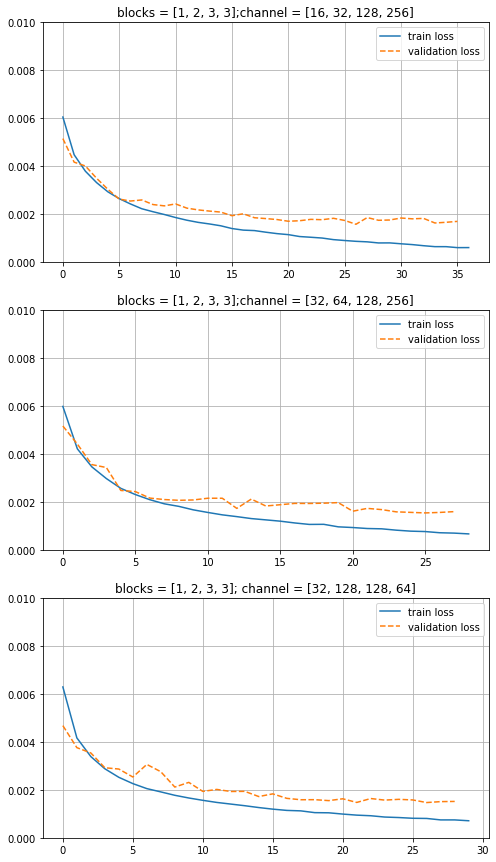

In [27]:
plt.figure(figsize=[8,15])

plt.subplot(3,1,1)
plt.ylim(-.00, .01)
plt.plot([i for i in range(len(train_loss_summary_1[str(channel_summary[0])]))],train_loss_summary_1[str(channel_summary[0])], '',label = 'train loss')
plt.plot([i for i in range(len(valid_loss_summary_1[str(channel_summary[0])]))],valid_loss_summary_1[str(channel_summary[0])], '--',label = 'validation loss')
plt.title(f'blocks = {str([1,2,3,3])};channel = {str(channel_summary[0])}')
plt.grid()
plt.legend()


plt.subplot(3,1,2)
plt.ylim(-.00, .01)
plt.plot([i for i in range(len(train_loss_summary_1[str(channel_summary[1])]))],train_loss_summary_1[str(channel_summary[1])], '',label = 'train loss')
plt.plot([i for i in range(len(valid_loss_summary_1[str(channel_summary[1])]))],valid_loss_summary_1[str(channel_summary[1])], '--',label = 'validation loss')
plt.title(f'blocks = {str([1,2,3,3])};channel = {str(channel_summary[1])}')
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.ylim(-.00, .01)
plt.plot([i for i in range(len(train_loss_summary_1[str(channel_summary[2])]))],train_loss_summary_1[str(channel_summary[2])], '',label = 'train loss')
plt.plot([i for i in range(len(valid_loss_summary_1[str(channel_summary[2])]))],valid_loss_summary_1[str(channel_summary[2])], '--',label = 'validation loss')
plt.title(f'blocks = {str([1,2,3,3])}; channel = {str(channel_summary[2])}')
plt.grid()
plt.legend()



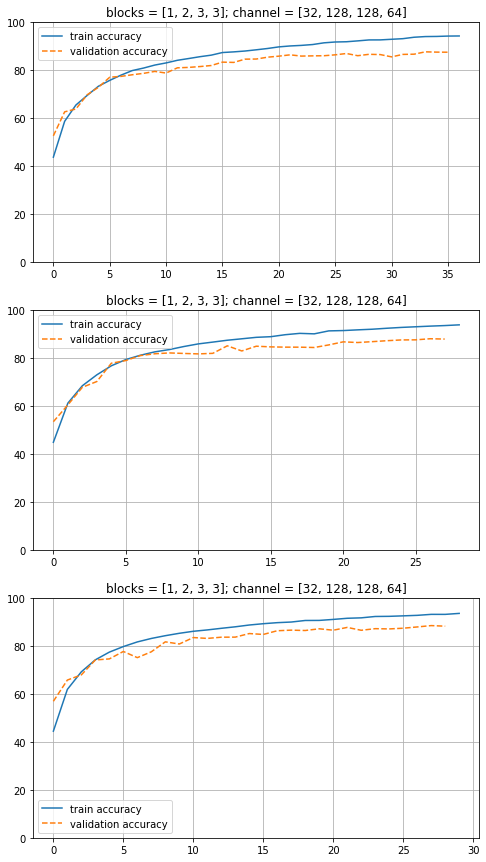

In [32]:
plt.figure(figsize=[8,15])

plt.subplot(3,1,1)
plt.plot([i for i in range(len(train_loss_summary_1[str(channel_summary[0])]))],train_acc_summary_1[str(channel_summary[0])], '',label = 'train accuracy')
plt.plot([i for i in range(len(valid_loss_summary_1[str(channel_summary[0])]))],valid_acc_summary_1[str(channel_summary[0])], '--',label = 'validation accuracy')
plt.title(f'blocks = {str([1,2,3,3])}; channel = {str(channel_summary[2])}')
plt.ylim(-.00, 100.0)
plt.grid()
plt.legend()


plt.subplot(3,1,2)
plt.plot([i for i in range(len(train_loss_summary_1[str(channel_summary[1])]))],train_acc_summary_1[str(channel_summary[1])], '',label = 'train accuracy')
plt.plot([i for i in range(len(valid_loss_summary_1[str(channel_summary[1])]))],valid_acc_summary_1[str(channel_summary[1])], '--',label = 'validation accuracy')
plt.title(f'blocks = {str([1,2,3,3])}; channel = {str(channel_summary[2])}')
plt.ylim(-.00, 100.0)
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.plot([i for i in range(len(train_loss_summary_1[str(channel_summary[2])]))],train_acc_summary_1[str(channel_summary[2])], '',label = 'train accuracy')
plt.plot([i for i in range(len(valid_loss_summary_1[str(channel_summary[2])]))],valid_acc_summary_1[str(channel_summary[2])], '--',label = 'validation accuracy')
plt.title(f'blocks = {str([1,2,3,3])}; channel = {str(channel_summary[2])}')
plt.ylim(-.00, 100.0)
plt.grid()
plt.legend()



<BarContainer object of 1 artists>

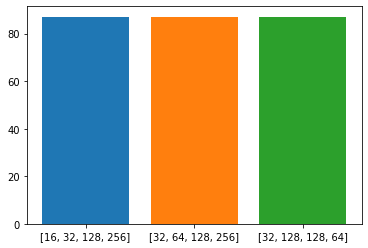

In [31]:
plt.bar(str(channel_summary[0]),test_acc_summary_1[str(channel_summary[0])], label = 'test accuracy')
plt.bar(str(channel_summary[1]),test_acc_summary_1[str(channel_summary[1])], label = 'test accuracy')
plt.bar(str(channel_summary[2]),test_acc_summary_1[str(channel_summary[2])], label = 'test accuracy')

In [18]:
train_loss_summary_2 = {}
train_acc_summary_2 = {}
valid_loss_summary_2 = {}
valid_acc_summary_2 = {}
test_acc_summary_2 = {}

channel_summary_2 = [[128,32,256,32],[64,64,128,256],[256,64,64,128]]
for i,channel in enumerate(channel_summary_2):
  net = ResNet_Adjustable(BottleNeck, channel, layer_para['option2'])
  train_loss, valid_loss,train_acc, val_acc, test_acc = train(net)

  train_loss_summary_2[str(channel_summary_2[i])] = train_loss
  train_acc_summary_2[str(channel_summary_2[i])] = train_acc

  valid_loss_summary_2[str(channel_summary_2[i])] = valid_loss
  valid_acc_summary_2[str(channel_summary_2[i])] = val_acc
  test_acc_summary_2[str(channel_summary_2[i])] = test_acc




==> Building model..
==> Summarize model..
Layer (type:depth-idx)                        Param #
DataParallel                                  --
├─ResNet: 1-1                                 --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       3,456
│    │    └─BatchNorm2d: 3-2                  256
│    │    └─ReLU: 3-3                         --
│    └─Sequential: 2-2                        --
│    │    └─BottleNeck: 3-4                   297,472
│    └─Sequential: 2-3                        --
│    │    └─BottleNeck: 3-5                   95,872
│    │    └─BottleNeck: 3-6                   17,792
│    └─Sequential: 2-4                        --
│    │    └─BottleNeck: 3-7                   1,020,928
│    │    └─BottleNeck: 3-8                   1,117,184
│    │    └─BottleNeck: 3-9                   1,117,184
│    │    └─BottleNeck: 3-10                  1,117,184
│    └─Sequential: 2-5                        --
│    │    └─BottleNeck: 3

In [19]:
test_acc_summary_2

{'[128, 32, 256, 32]': 88.25120192307692,
 '[64, 64, 128, 256]': 85.41666666666667,
 '[256, 64, 64, 128]': 86.99919871794872}

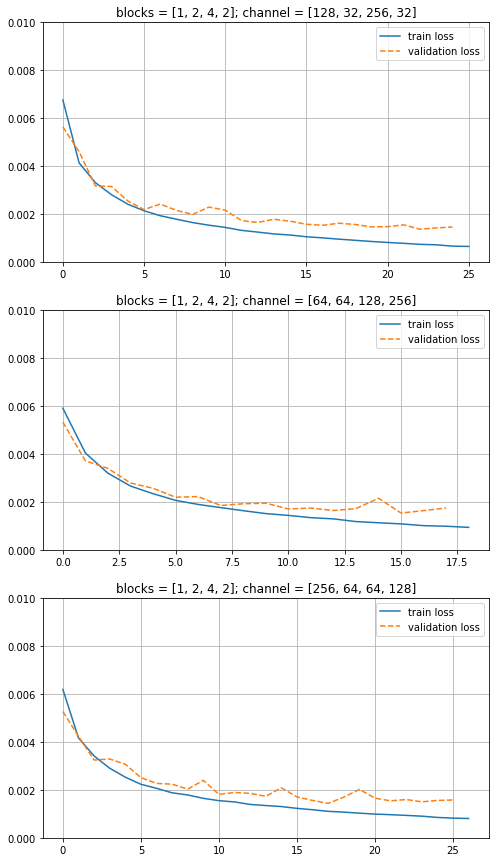

In [22]:
plt.figure(figsize=[8,15])

plt.subplot(3,1,1)
plt.ylim(-.00, .01)
plt.plot([i for i in range(len(train_loss_summary_2[str(channel_summary_2[0])]))],train_loss_summary_2[str(channel_summary_2[0])], '',label = 'train loss')
plt.plot([i for i in range(len(valid_loss_summary_2[str(channel_summary_2[0])]))],valid_loss_summary_2[str(channel_summary_2[0])], '--',label = 'validation loss')
plt.title(f'blocks = {str([1,2,4,2])}; channel = {str(channel_summary_2[0])}')
plt.grid()
plt.legend()


plt.subplot(3,1,2)
plt.ylim(-.00, .01)
plt.plot([i for i in range(len(train_loss_summary_2[str(channel_summary_2[1])]))],train_loss_summary_2[str(channel_summary_2[1])], '',label = 'train loss')
plt.plot([i for i in range(len(valid_loss_summary_2[str(channel_summary_2[1])]))],valid_loss_summary_2[str(channel_summary_2[1])], '--',label = 'validation loss')
plt.title(f'blocks = {str([1,2,4,2])}; channel = {str(channel_summary_2[1])}')
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.ylim(-.00, .01)
plt.plot([i for i in range(len(train_loss_summary_2[str(channel_summary_2[2])]))],train_loss_summary_2[str(channel_summary_2[2])], '',label = 'train loss')
plt.plot([i for i in range(len(valid_loss_summary_2[str(channel_summary_2[2])]))],valid_loss_summary_2[str(channel_summary_2[2])], '--',label = 'validation loss')
plt.title(f'blocks = {str([1,2,4,2])}; channel = {str(channel_summary_2[2])}')
plt.grid()
plt.legend()



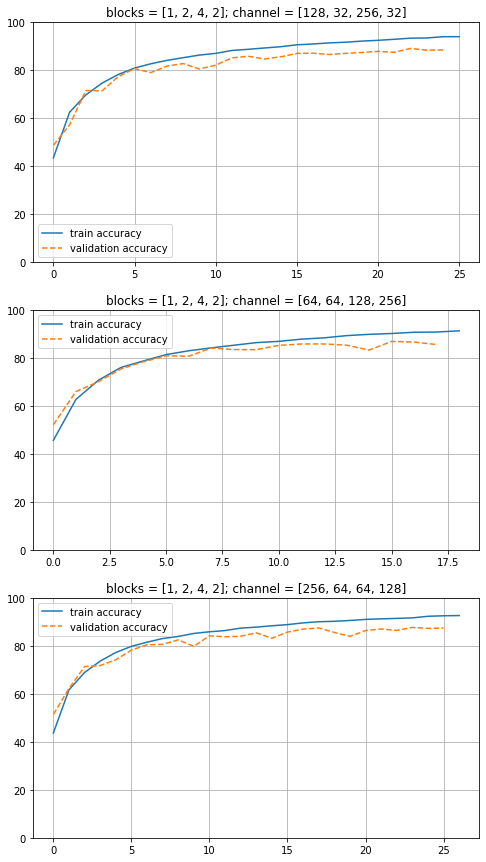

In [23]:
plt.figure(figsize=[8,15])

plt.subplot(3,1,1)
plt.plot([i for i in range(len(train_loss_summary_2[str(channel_summary_2[0])]))],train_acc_summary_2[str(channel_summary_2[0])], '',label = 'train accuracy')
plt.plot([i for i in range(len(valid_loss_summary_2[str(channel_summary_2[0])]))],valid_acc_summary_2[str(channel_summary_2[0])], '--',label = 'validation accuracy')
plt.title(f'blocks = {str([1,2,4,2])}; channel = {str(channel_summary_2[0])}')
plt.ylim(-.00, 100.0)
plt.grid()
plt.legend()


plt.subplot(3,1,2)
plt.plot([i for i in range(len(train_loss_summary_2[str(channel_summary_2[1])]))],train_acc_summary_2[str(channel_summary_2[1])], '',label = 'train accuracy')
plt.plot([i for i in range(len(valid_loss_summary_2[str(channel_summary_2[1])]))],valid_acc_summary_2[str(channel_summary_2[1])], '--',label = 'validation accuracy')
plt.title(f'blocks = {str([1,2,4,2])}; channel = {str(channel_summary_2[1])}')
plt.ylim(-.00, 100.0)
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.plot([i for i in range(len(train_loss_summary_2[str(channel_summary_2[2])]))],train_acc_summary_2[str(channel_summary_2[2])], '',label = 'train accuracy')
plt.plot([i for i in range(len(valid_loss_summary_2[str(channel_summary_2[2])]))],valid_acc_summary_2[str(channel_summary_2[2])], '--',label = 'validation accuracy')
plt.title(f'blocks = {str([1,2,4,2])}; channel = {str(channel_summary_2[2])}')
plt.ylim(-.00, 100.0)
plt.grid()
plt.legend()

